In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from id01lib import id01h5
from id01lib.xrd.qconversion import scan_to_qspace_h5,qconvert_mgrid
from id01lib.xrd.geometries import ID01psic
from mayavi import mlab

%gui qt5

In [4]:
ls /users/zatterin/Documents/beam/20180407_HC3505

20180407_HC3505_e17060.h5   20180407_HC3505_qconvert.ipynb
20180407_HC3505_e17089.h5   20180407_HC3505_qconvert_stitch.ipynb
20180407_HC3505_e17090.h5   20180407_HC3505_qconvert_stitch_peakpos.ipynb
20180407_HC3505_kmap.ipynb  20180412_HC3505_e17089.h5


In [13]:
def qconvert(scan_no, nbins, cen_pix=[336.10, 238.65], det_distance=0.411):

    # Sample and scans
    fname = '/users/zatterin/Documents/beam/20180407_HC3505/20180407_HC3505_e17090.h5'
    sample = 'e17090'

    # Experimental parameters
    nrj=8
    print('sample: {0}'.format(sample))
    print('WARNING: cen_pix={0}, det_distance={1}'.format(cen_pix, det_distance))

    # Open the h5 file
    with h5py.File(fname) as h5f:

        # read / set offsets
        scan = h5f['/{0}/{1}.1'.format(sample,scan_no)]
        phi_off = h5f['/{0}/{1}.1/instrument/positioners/phi'.format(sample,scan_no)].value
        rhx_off = h5f['/{0}/{1}.1/instrument/positioners/rhx'.format(sample,scan_no)].value
        rhy_off = h5f['/{0}/{1}.1/instrument/positioners/rhy'.format(sample,scan_no)].value
        nu_off =  h5f['/{0}/{1}.1/instrument/positioners/nu'.format(sample,scan_no)].value
        ID01psic().usemotors = set(('eta', 'phi', 'nu', 'delta'))

        # set to corresponding offsets if needed
#         ID01psic().set_offsets(eta=-4.1001, rhy=0.065, rhx=0, phi=0.809+phi_off, nu=0)
        ID01psic().set_offsets(eta=1.013, rhy=0, rhx=0, phi=0, nu=0.)


        # convert to q space
        qx, qy, qz, gint = scan_to_qspace_h5(scan, 
                                             cen_pix=(cen_pix[1],cen_pix[0]), 
                                             distance=det_distance, 
                                             energy=8,
                                             nbins=nbins)
        
        return qx, qy, qz, gint
    
def mlab_axes_tweak(axes):
    # Tweak the appearance of the axes labels
    axes.property.line_width = 2
    
    axes.label_text_property.font_family = 'arial'
    axes.label_text_property.orientation = 0
    axes.label_text_property.italic = False
    axes.label_text_property.bold = False

    axes.title_text_property.font_family = 'arial'
    
    axes.axes.font_factor = 1
    axes.axes.label_format = '%2.2f'
    axes.axes.corner_offset = 0.02


def plone(s, fig, xshift=0.05, yshift=0.05, zshift=0.05, t=1e-6, projections=True, op=1, transp=True):

    # make the projections
    x,y,z = s[3].sum(0), s[3].sum(1), s[3].sum(2)

    # Make a figure
    mlab.clf(fig)

    # Source the 3D data
    surf = mlab.pipeline.scalar_field(*s, figure=fig)

    # Plot it 
    mlab.pipeline.iso_surface(surf, contours=20, opacity=op, transparent=transp, vmin=2, vmax=4)

    if projections:
        # Source the projections
        proj = []
        for img in (x,y,z):
            im = mlab.pipeline.array2d_source(img, figure=fig)
            proj.append(im)

        # Tweak spacing and origin
        origin = surf.origin
        spacing = surf.spacing

        for p in proj: 
            p.origin = origin
        proj[0].spacing = spacing[1], spacing[2], spacing[0]
        proj[1].spacing = spacing[0], spacing[2], spacing[1]
        proj[2].spacing = spacing[0], spacing[1], spacing[2]

        # Threshold them and make the surfaces
        psurf = []
        for p, i in zip(proj, (x,y,z)):
            tresh = mlab.pipeline.threshold(p, low=i.min()+t)
            stresh = mlab.pipeline.surface(tresh)
            stresh.enable_contours = True
            stresh.contour.number_of_contours = 30
            stresh.contour.filled_contours = True
            psurf.append(stresh)

        # Tweak position of projection
        psurf[0].actor.actor.origin = origin
        psurf[1].actor.actor.origin = origin
        psurf[2].actor.actor.origin = origin

        psurf[0].actor.actor.position = [0-xshift,0,0]
        psurf[1].actor.actor.position = [0,0-yshift,0]
        psurf[2].actor.actor.position = [0,0,0-zshift]

        # Tweak orientation of projection
        psurf[1].actor.actor.orientation = [90,0,0]
        psurf[0].actor.actor.orientation = [90,90,0]

    # Tweak the axes
    qx, qy, qz = s[0][:,0,0], s[1][0,:,0], s[2][0,0,:]

    axes = mlab.axes(surf, extent=[qx.min()-xshift, qx.max(), 
                                   qy.min()-yshift, qy.max(), 
                                   qz.min()-zshift, qz.max()],nb_labels=3)

    mlab.outline(extent=[qx.min()-xshift, qx.max(), 
                         qy.min()-yshift, qy.max(), 
                         qz.min()-zshift, qz.max()])
    mlab_axes_tweak(axes)
    fig.scene.parallel_projection = True
    fig.scene.line_smoothing = True
    fig.scene.render_window.point_smoothing = True
    fig.scene.render_window.line_smoothing = True
    fig.scene.render_window.polygon_smoothing = True
    fig.scene.render_window.multi_samples = 8 # Try with 4 if you think this is slow
    # fig.scene.render_window.aa_frames = 8 # Try with 4 if you think this is slow


    mlab.view(azimuth=59)
    fig.scene.reset_zoom()
    # mlab.colorbar()
    # mlab.show()
    return fig

# One peak

In [9]:
mlab.init_notebook(backend='png')
mlab.options.backend = 'simple'

Notebook initialized with png backend.


In [11]:
scan = 42
qx, qy, qz, gint = qconvert(scan, (100,100,100))
# qx, qy, qz, gint = qconvert(scan, (-1,-1,-1))
qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 4.7)
s = (qxx, qyy, qzz, i)

sample: e16014
Selected /e16014/42.1
Offsets used: nu = 0.0, delta = 0.0, rhy = 0.0, rhx = 0.0, phi = 0.0, eta = 1.013, mu = 0.0, rhz = 0.0, 
Max. number of bins: 529, 514, 515
Using binning: (100, 100, 100)

Gridding with bins: (100, 100, 100)


Make it a little bit nicer, and plot the projections on the sides. One scan at a time is plotted.

In [12]:
i.min(), i.max()

(1.1447305955682856, 5.844730595568286)


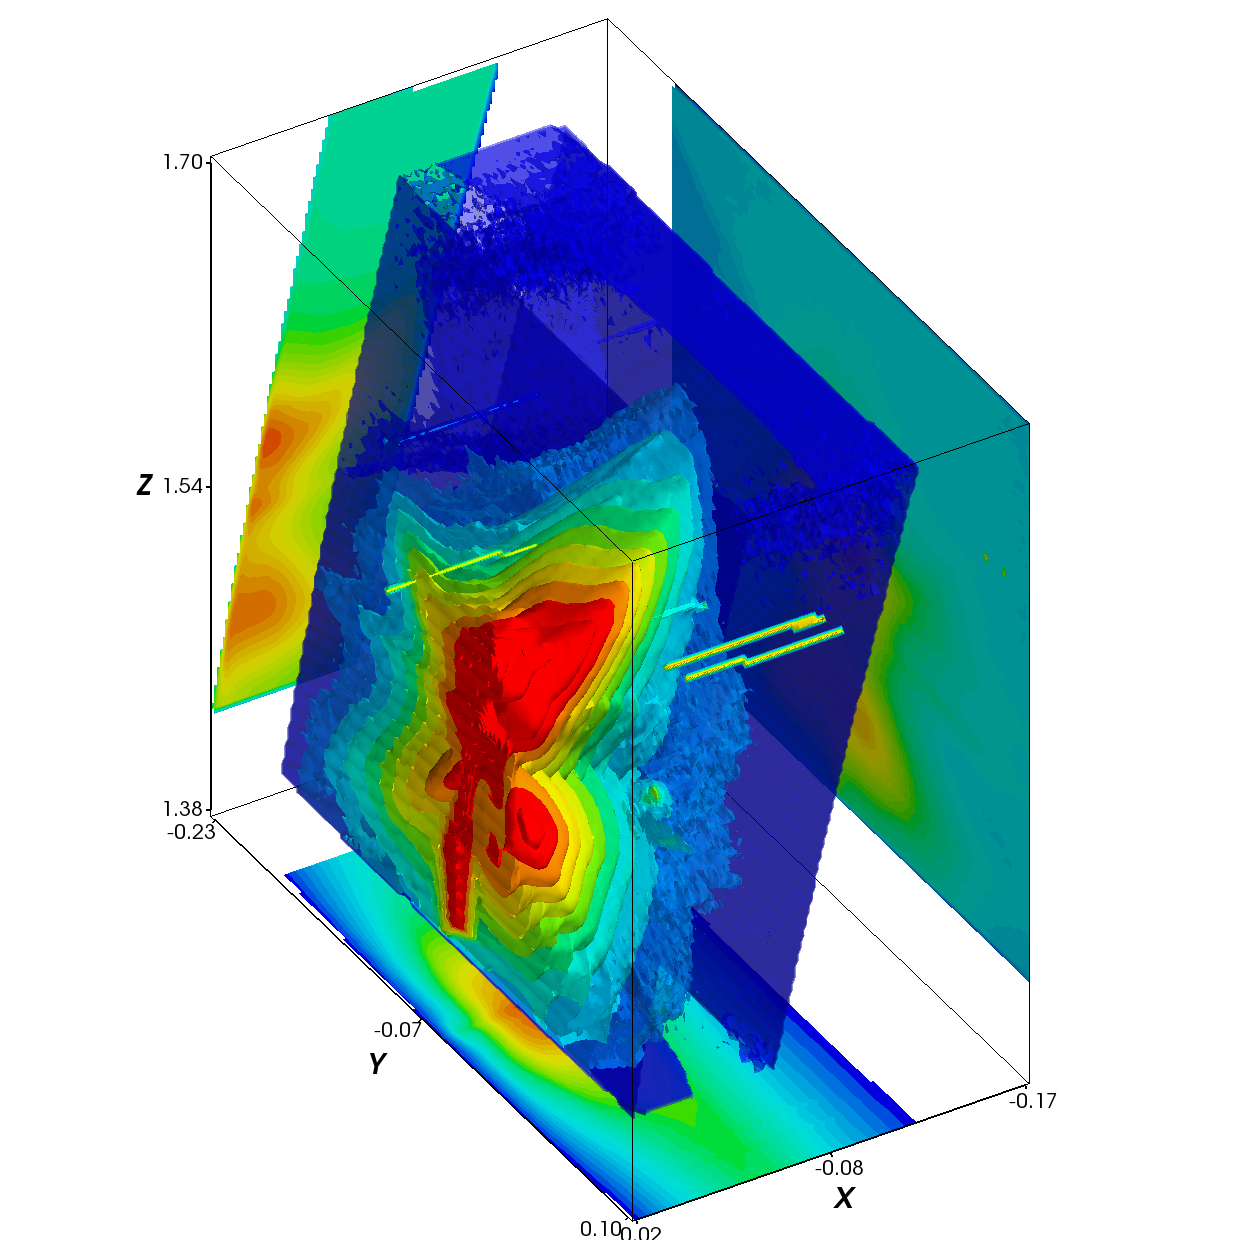

In [14]:
fig = mlab.figure(size=(1240,1240),fgcolor=(0,0,0),bgcolor=(1,1,1))
plone(s, fig)

In [8]:
fig.scene.save_gl2ps('113.pdf')

# Two peaks

In [41]:
n, n2 = 42, 45

s = {}
for scan in (n,n2):
    qx, qy, qz, gint = qconvert(scan, (100,100,100))
    qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 4)
    s[scan] = (qxx, qyy, qzz, i)

sample: e16014
Selected /e16014/42.1
Offsets used: nu = 0.0, delta = 0.0, rhy = 0.0, rhx = 0.0, phi = 0.0, eta = 1.013, mu = 0.0, rhz = 0.0, 
Max. number of bins: 529, 514, 515
Using binning: (100, 100, 100)

Gridding with bins: (100, 100, 100)
sample: e16014
Selected /e16014/45.1
Offsets used: nu = 0.0, delta = 0.0, rhy = 0.0, rhx = 0.0, phi = 0.0, eta = 1.013, mu = 0.0, rhz = 0.0, 
Max. number of bins: 479, 514, 516
Using binning: (100, 100, 100)

Gridding with bins: (100, 100, 100)


In [37]:
s[42][3].shape

(100, 100)

In [42]:
fig = mlab.figure(size=(1240,1240),fgcolor=(0,0,0),bgcolor=(1,1,1))


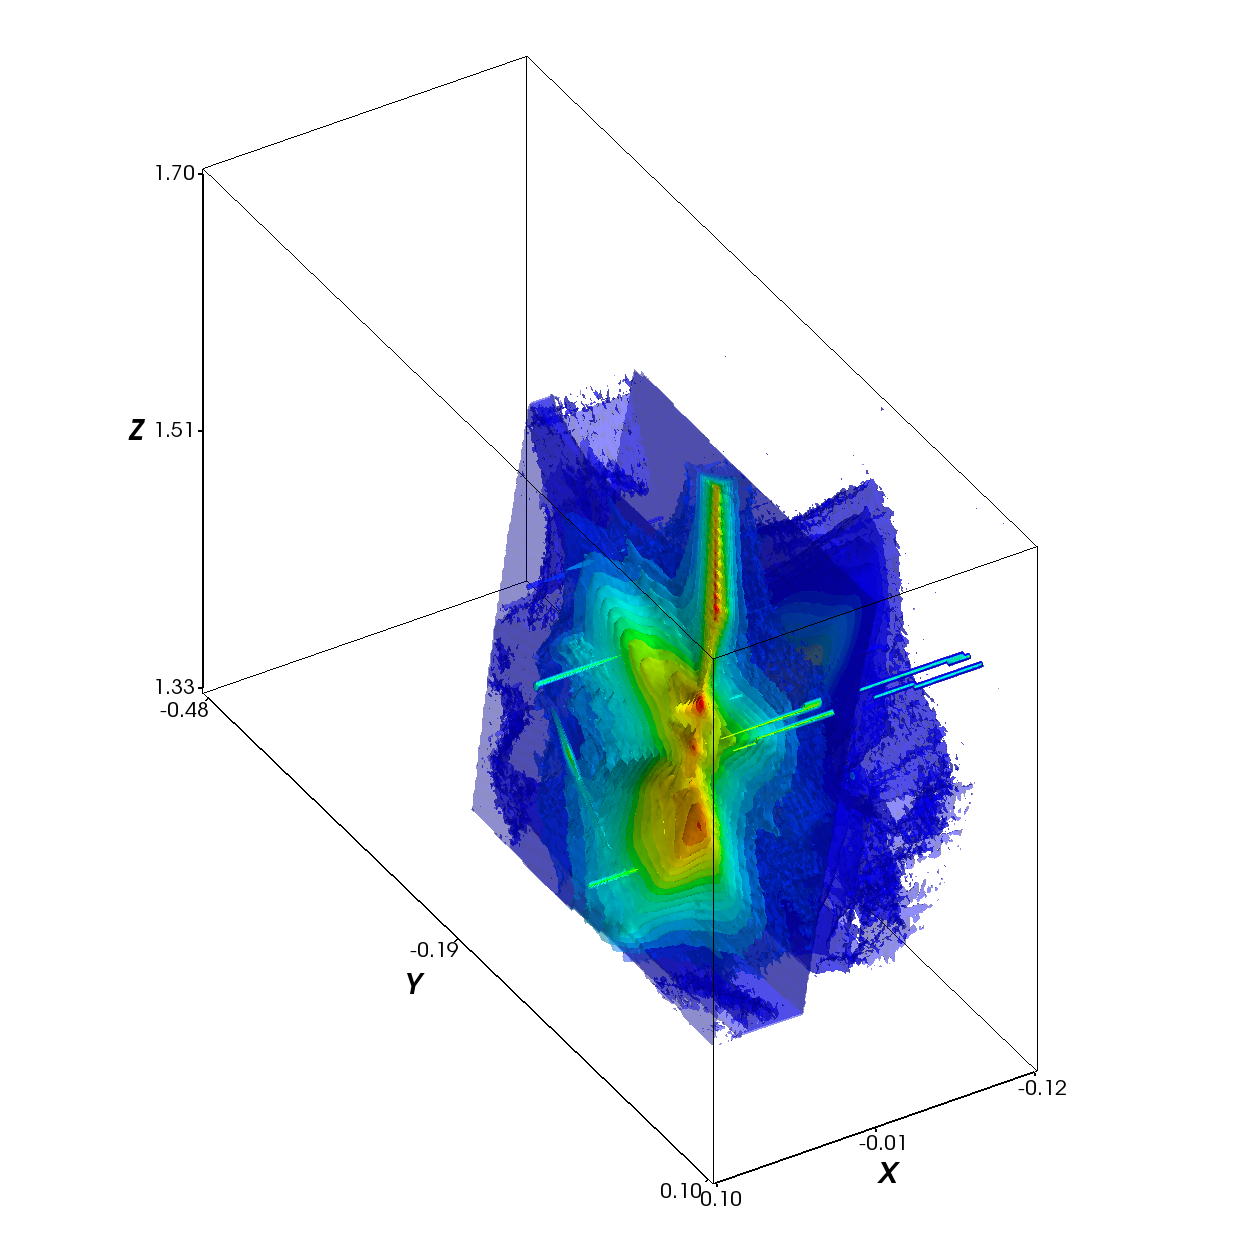

In [43]:
op = 1
t=0.001
transp = True
yshift = 0.3
zshift = 0.1
xshift = 0.0

projections = False

# make the projections
x,y,z = s[n][3].sum(0), s[n][3].sum(1), s[n][3].sum(2)
x2,y2,z2 = s[n2][3].sum(0), s[n2][3].sum(1), s[n2][3].sum(2)
lproj = [x,y,z,x2,y2,z2]

# Make a figure
mlab.clf(fig)

# Source the 3D data
surf = mlab.pipeline.scalar_field(*s[n], figure=fig)
surf2 = mlab.pipeline.scalar_field(*s[n2], figure=fig)

# t = mlab.pipeline.threshold(surf, low=2.8)
# t2 = mlab.pipeline.threshold(surf2, low=2.8)

# Plot it 
mlab.pipeline.iso_surface(surf, contours=20, opacity=op, transparent=transp, vmin=3, vmax=5) 
mlab.pipeline.iso_surface(surf2, contours=20, opacity=op, transparent=transp, vmin=2, vmax=5)

if projections:
    # Source the projections
    proj = []
    for img in lproj:
        im = mlab.pipeline.array2d_source(img, figure=fig)
        proj.append(im)

    # Tweak spacing and origin
    origin = surf.origin
    spacing = surf.spacing
    
    origin2 = surf2.origin
    spacing2 = surf2.spacing

    # Projections of the first surface
    for p in proj[0:3]: 
        p.origin = origin
    proj[0].spacing = spacing[1], spacing[2], spacing[0]
    proj[1].spacing = spacing[0], spacing[2], spacing[1]
    proj[2].spacing = spacing[0], spacing[1], spacing[2]
    
    # Projections of the second surface
    for p in proj[3:6]:
        p.origin = origin2
    proj[3].spacing = spacing2[1], spacing2[2], spacing2[0]
    proj[4].spacing = spacing2[0], spacing2[2], spacing2[1]
    proj[5].spacing = spacing2[0], spacing2[1], spacing2[2]
    
    # Threshold them and make the surfaces
    psurf = []
    for p, i in zip(proj, lproj):
        tresh = mlab.pipeline.threshold(p, low=i.min()+t)
        stresh = mlab.pipeline.surface(tresh)
        stresh.enable_contours = True
        stresh.contour.number_of_contours = 30
        stresh.contour.filled_contours = True
        psurf.append(stresh)
    
    ## First surface
    # Tweak position of projection
    psurf[0].actor.actor.origin = origin
    psurf[1].actor.actor.origin = origin
    psurf[2].actor.actor.origin = origin

    psurf[0].actor.actor.position = [0-xshift,0,0]
    psurf[1].actor.actor.position = [0,0-yshift,0]
    psurf[2].actor.actor.position = [0,0,0-zshift]

    # Tweak orientation of projection
    psurf[1].actor.actor.orientation = [90,0,0]
    psurf[0].actor.actor.orientation = [90,90,0]
    
    ## Second surface
    # Tweak position of projection
    psurf[3].actor.actor.origin = origin2
    psurf[4].actor.actor.origin = origin2
    psurf[5].actor.actor.origin = origin2

    psurf[3].actor.actor.position = [0-0.033,0,0]
    psurf[4].actor.actor.position = [0,0-yshift,0]
    psurf[5].actor.actor.position = [0,0,0-0.25]

    # Tweak orientation of projection
    psurf[4].actor.actor.orientation = [90,0,0]
    psurf[3].actor.actor.orientation = [90,90,0]

# Tweak the axes
qx, qy, qz = s[n2][0][:,0,0], s[n2][1][0,:,0], s[n2][2][0,0,:]
qx2, qy2, qz2 = s[n][0][:,0,0], s[n][1][0,:,0], s[n][2][0,0,:]

axes = mlab.axes(surf, extent=[qx2.min()-xshift, qx.max(), 
                               qy.min()-yshift, qy.max(), 
                               qz2.min()-zshift, qz.max()],nb_labels=3)

mlab.outline(extent=[qx2.min()-xshift, qx.max(), 
                   qy.min()-yshift, qy.max(), 
                   qz2.min()-zshift, qz.max()])

mlab_axes_tweak(axes)

fig.scene.parallel_projection = True
fig.scene.line_smoothing = True
fig.scene.reset_zoom()

mlab.view(azimuth=59,distance=1)
mlab.show()
# mlab.savefig('103.pdf')
fig